## Movie review data preparation
This notebook handles the data preparation for a neural network to predict the sentiment of movie reviews.

[torchtext](https://pytorch.org/text/stable/index.html) is used for handling the input data

Additional dependencies:  
[spacy](https://spacy.io) for tokenizing (used by torchtext)

In [1]:
import os
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt

from torchtext.legacy.data import Field
from torchtext.data import get_tokenizer

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

In [2]:
# install spacy and download word embeddings
# !pip install spacy
# !python3 -m spacy download en_core_web_sm

In [3]:
# class to hold a dataset
# custom datasets need to implement init, len, and getitem
class MovieReviewDataset(Dataset):
    def __init__(self, filename, tokenizer, vocab):
        self.tokenizer = tokenizer
        self.vocab = vocab

        self.data = pd.read_csv(filename, delimiter='\t')
          
    def __getitem__(self, idx):
        # tokenize sentence
        tokens = self.tokenizer(self.data.iloc[idx]['sentence'])
        # numericalize
        tokens_numerical = [self.vocab.stoi[token] for token in tokens]
        label = self.data.iloc[idx]['label']
        return tokens_numerical, label
    
    def __len__(self):
        return len(self.data)
    
    
# custom collate function to handle variable-size input
def collate(batch, padding_token_numerical):
    # get max sample size: item[0] is the input sentence split into numerical tokens
    tokens = [sample[0] for sample in batch]
    max_size = max(map(len, tokens))
    # create input array with padding such that each element has the same size
    input_data = []
    for item in tokens:
        # required padding
        npad = max_size - len(item)
        input_data.append(item + [padding_token_numerical] * npad)
    
    # convert to tensors
    input_data = torch.LongTensor(input_data)
    labels = torch.FloatTensor([item[1] for item in batch])
    return [input_data, labels]

In [4]:
# Build vocabulary from training data
data_path = os.path.join(os.path.expanduser('~'), 'surfdrive/Shared/datasets/stanford_sentiment_treebank_v2')

# tokenizer for splitting input sentences
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

# load raw training data
raw_train_data = pd.read_csv(os.path.join(data_path, 'train.tsv'), delimiter='\t')

# TODO: why does this split input on individual letters instead of words?
# TEXT = Field(sequential=True, tokenize='spacy', tokenizer_language='en_core_web_sm')
# TEXT.build_vocab(raw_train_data['sentence'], vectors='glove.6B.100d')

# split input into tokens
train_tokens = [tokenizer(sentence) for sentence in raw_train_data['sentence']]

# Create field and build vocabulary
text_field = Field()
text_field.build_vocab(train_tokens, vectors='glove.6B.100d')
vocab_size = len(text_field.vocab.freqs) + 2  # add the padding and unknown token
embedding_size = text_field.vocab.vectors.shape[1]
padding_idx = text_field.vocab.stoi[text_field.pad_token]
unknown_idx = text_field.vocab.stoi[text_field.unk_token]

# define collate function with now known padding token
collate_func = lambda batch: collate(batch, padding_idx)

print(f'Vocab size: {vocab_size}')
print(f'Embedding size: {embedding_size}')
print(f'Padding token index: {padding_idx}')
print(f'Unknown token index: {unknown_idx}')

Vocab size: 13889
Embedding size: 100
Padding token index: 1
Unknown token index: 0


In [5]:
# Load data into PyTorch dataset
# These datasets return the input as numerical values, suited for input to the model

train_data = MovieReviewDataset(os.path.join(data_path, 'train.tsv'), tokenizer, text_field.vocab)
val_data = MovieReviewDataset(os.path.join(data_path, 'validation.tsv'), tokenizer, text_field.vocab)

In [6]:
# Create iterators for the data
batch_size = 64

train_data_iterator = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
val_data_iterator = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=collate_func)

# test
features, labels = next(iter(train_data_iterator))
print(features.size())
print(labels.size())
print(features)

torch.Size([64, 39])
torch.Size([64])
tensor([[   8, 7776,    5,  ...,    1,    1,    1],
        [5529,    1,    1,  ...,    1,    1,    1],
        [   4,  896,  242,  ...,    1,    1,    1],
        ...,
        [  14,  354, 1758,  ...,    1,    1,    1],
        [  33,    2,  994,  ...,    1,    1,    1],
        [3962,   11,   17,  ...,    1,    1,    1]])


In [7]:
# select device to run on
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')
# print(f'PyTorch will use {device}')

# crashes on GPU after ~1.5 epoch, only run on cpu for now
device = torch.device('cpu')

In [8]:
# create a model
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_size, n_filters, filter_sizes, padding_idx,
                dropout, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=padding_idx)
        
        self.conv_layers = nn.ModuleList()
        for filter_size in filter_sizes:
            layer = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_size, embedding_size))
            self.conv_layers.append(layer)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(n_filters * len(filter_sizes), output_dim)
    
    def forward(self, text):
        # shape = [batch size, max nword per sentence]
        embedding = self.embedding(text).unsqueeze(1)
        # shape = [batch_size, 1, nword, embedding dim]
        conved = [F.relu(conv(embedding)).squeeze(3) for conv in self.conv_layers]
        # shape = len(filter_sizes) list of [batch_size, n_filter, nword - filter_size + 1]
        pooled = [F.max_pool1d(out, out.shape[2]).squeeze(2) for out in conved]
        # shape = len(filter_sizes) list of [batch_size, n_filter]
        concat = torch.cat(pooled, dim=1)
        # shape = [batch_size * len(filter_sizes), n_filter]
        dropped = self.dropout(concat)
        return torch.sigmoid(self.fc(dropped))

In [9]:
# init a model
output_dim = 1
dropout = .2
n_filters = 128
filter_sizes = [3, 4, 5]

model = Model(vocab_size, embedding_size, n_filters, filter_sizes, padding_idx, dropout, output_dim)
# copy pre-trained embeddings into model
model.embedding.weight.data.copy_(text_field.vocab.vectors)

model = model.to(device)

In [10]:
# Define training and evaluation functions
# first define optimizer and loss function
optimizer = optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss().to(device)

# function to calculate accuracy
def accuracy(y_pred, y_true):
    y_pred = torch.round(y_pred)
    return (y_pred == y_true).sum() / len(y_pred)

def train(model, train_data, optimizer, loss_func, val_data=None):
    
    epoch_loss = 0
    epoch_acc = 0
    val_loss = 0
    val_acc = 0
    
    model.train()
    
    for batch in tqdm.tqdm(train_data):
        input_data, label = batch
        input_data = input_data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        predictions = model(input_data).squeeze(1)
        
        loss = loss_func(predictions, label)
        acc = accuracy(predictions, label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    epoch_loss /= len(train_data)
    epoch_acc /= len(train_data)
        
    # validation
    if val_data is not None:
        with torch.no_grad():
            for batch in val_data:
                input_data, label = batch
                input_data = input_data.to(device)
                label = label.to(device)
                
                predictions = model(input_data).squeeze(1)
                
                val_loss += loss_func(predictions, label).item()
                val_acc += accuracy(predictions, label).item()
                
            val_loss /= len(val_data)
            val_acc /= len(val_data)
                
                
    return epoch_loss, epoch_acc, val_loss, val_acc

def evaluate(model, data, loss_func):
    
    loss = 0
    acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in data:
            input_data, label = batch
            input_data = input_data.to(device)
            label = label.to(device)

            predictions = model(input_data).squeeze(1)
            
            loss += loss_func(predictions, label).item()
            acc += accuracy(predictions, label).item()
            
    loss /= len(data)
    acc /= len(data)
        
    return loss, acc

In [11]:
# do the training
epochs = 10
loss = np.zeros(epochs)
acc = np.zeros(epochs)
val_loss = np.zeros(epochs)
val_acc = np.zeros(epochs)
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = train(model, train_data_iterator, optimizer, loss_func, val_data=val_data_iterator)
    loss[epoch] = epoch_loss
    acc[epoch] = epoch_acc
    val_loss[epoch] = epoch_val_loss
    val_acc[epoch] = epoch_val_acc
    

100%|██████████| 1053/1053 [00:48<00:00, 21.72it/s]


In [12]:
# store the model
model.eval()
torch.save(model.state_dict(), 'movie_review_model.pytorch')

# store as ONNX, needs example input
# x = next(iter(train_data_iterator))[0]
# torch.onnx.export(model, x, 'move_review_model.onxx', opset_version=10)

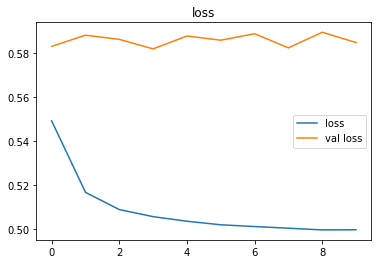

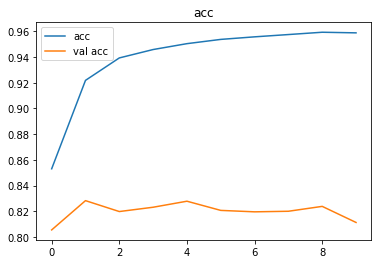

In [13]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val loss')
plt.title('loss')
plt.legend()

plt.figure()
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val acc')
plt.title('acc')
plt.legend()

In [14]:
# load model from disk
loaded_model = Model(vocab_size, embedding_size, n_filters, filter_sizes, padding_idx, dropout, output_dim)
loaded_model.load_state_dict(torch.load('movie_review_model.pytorch'))
loaded_model = loaded_model.to(device)
loaded_model.eval()

def predict_sentiment(sentence):
    # depends on loaded_model, tokenizer, text_field
    # convert sentence into tokens
    tokens = tokenizer(sentence)
    # must be at least the size of the largest filter
    if len(tokens) < max(filter_sizes):
        tokens += [text_field.pad_token] * (max(filter_size) - len(tokens))
    # convert to numerical and transfer to device
    tokens = [text_field.vocab.stoi[word] for word in tokens]
    tokens = torch.tensor(tokens).to(device)
    # add batch axis
    tensor = tokens.unsqueeze(0)
    prediction = loaded_model(tensor)
    return prediction.item()

In [15]:
# print some predictions from the (unlabeled) test set
sentences = pd.read_csv(os.path.join(data_path, 'test.tsv'), delimiter='\t')['sentence']
nmax = 10
classes = ['negative', 'positive']

for n, sentence in enumerate(sentences):
    if n == nmax:
        break
    output = predict_sentiment(sentence)
    predicted_class = classes[int(np.round(output))]
    print(f"\"{sentence}\" - {predicted_class} - {output:.2f}")

"uneasy mishmash of styles and genres ." - negative - 0.00
"this film 's relationship to actual tension is the same as what christmas-tree flocking in a spray can is to actual snow : a poor -- if durable -- imitation ." - negative - 0.00
"by the end of no such thing the audience , like beatrice , has a watchful affection for the monster ." - positive - 1.00
"director rob marshall went out gunning to make a great one ." - negative - 0.24
"lathan and diggs have considerable personal charm , and their screen rapport makes the old story seem new ." - positive - 1.00
"a well-made and often lovely depiction of the mysteries of friendship ." - positive - 1.00
"none of this violates the letter of behan 's book , but missing is its spirit , its ribald , full-throated humor ." - negative - 0.00
"although it bangs a very cliched drum at times , this crowd-pleaser 's fresh dialogue , energetic music , and good-natured spunk are often infectious ." - positive - 1.00
"it is not a mass-market enterta